In [3]:
!pip install geopandas
!pip install geodatasets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/Colab Notebooks/IMT2220/T1/data'

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [7]:
df_empirical_Holocene = pd.read_csv(f"{data_path}/df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv(f"{data_path}/df_empirical_LGM.csv")

In [8]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [9]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


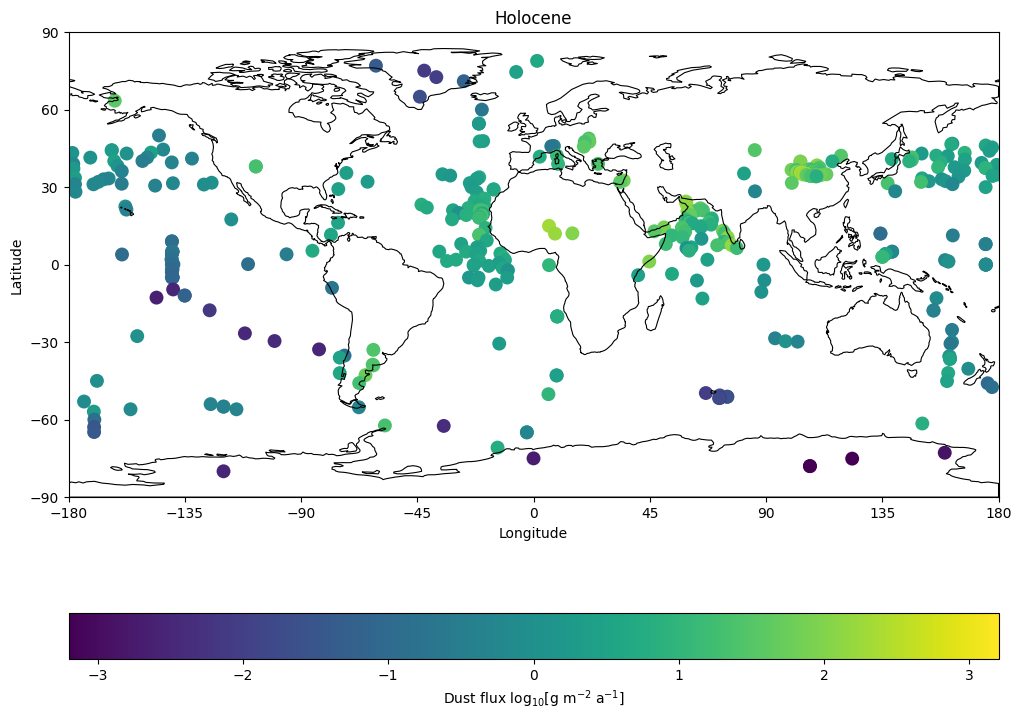

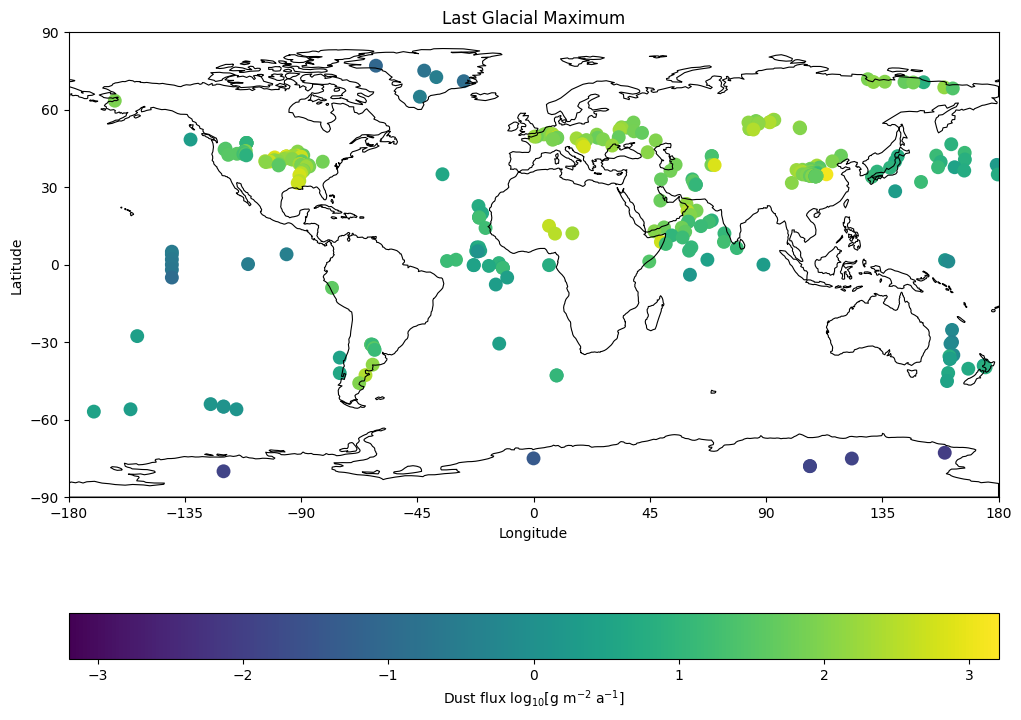

In [10]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [11]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

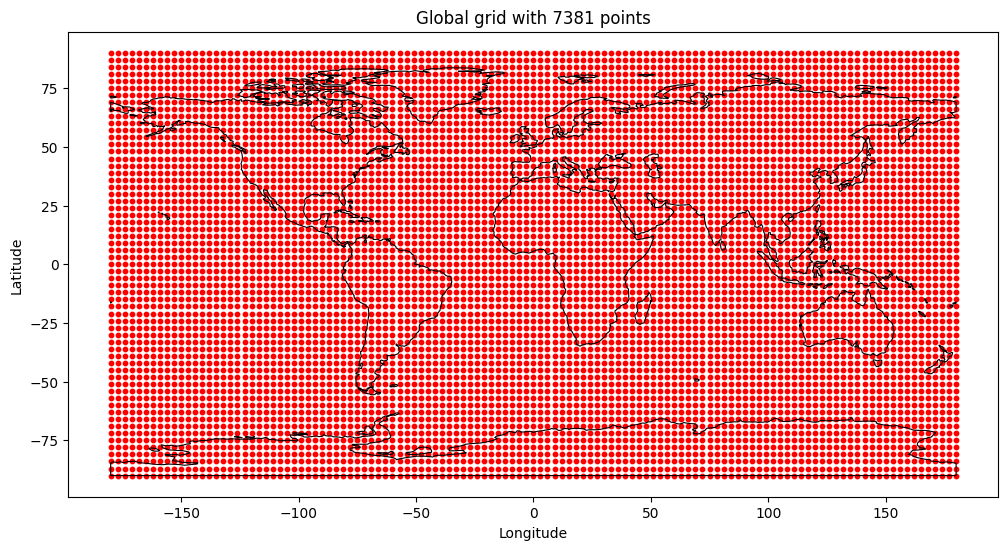

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [13]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """

    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [14]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    # Radious of the Earth is 6371 km
    R = 6371.0
    distance = R * np.arccos(np.sin(np.radians(x[1])) * np.sin(np.radians(y[1])) + np.cos(np.radians(x[1])) * np.cos(np.radians(y[1])) * np.cos(np.radians(x[0] - y[0])))
    return distance

In [15]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """

    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

In [16]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [17]:
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene_geodesic
df_global_grid["est_lgm"] = estimations_lgm_geodesic

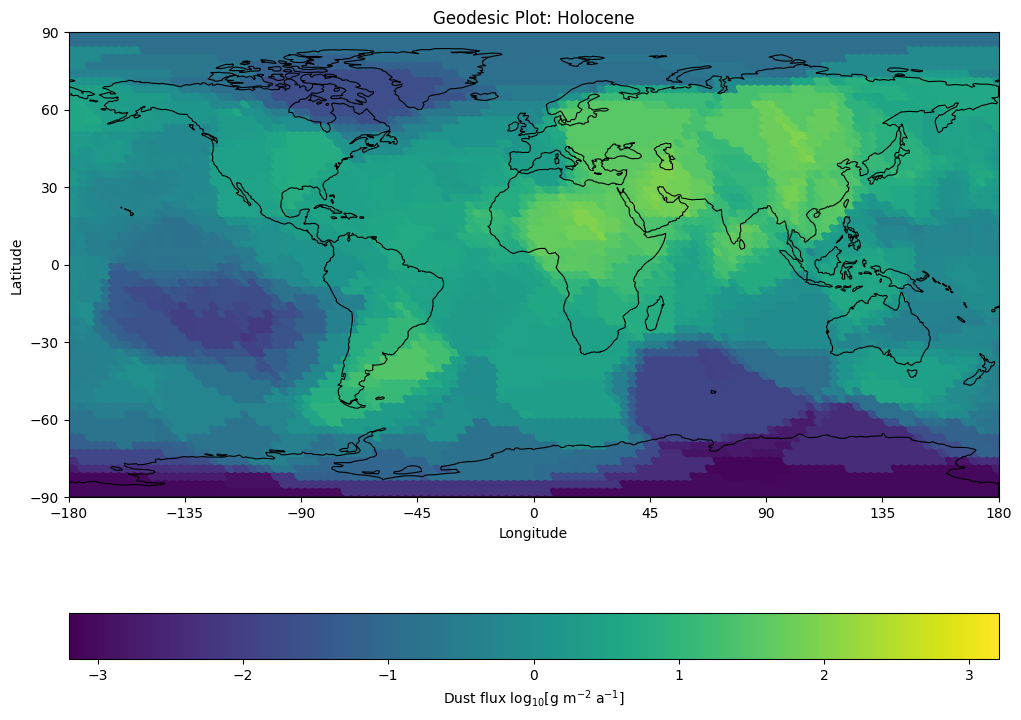

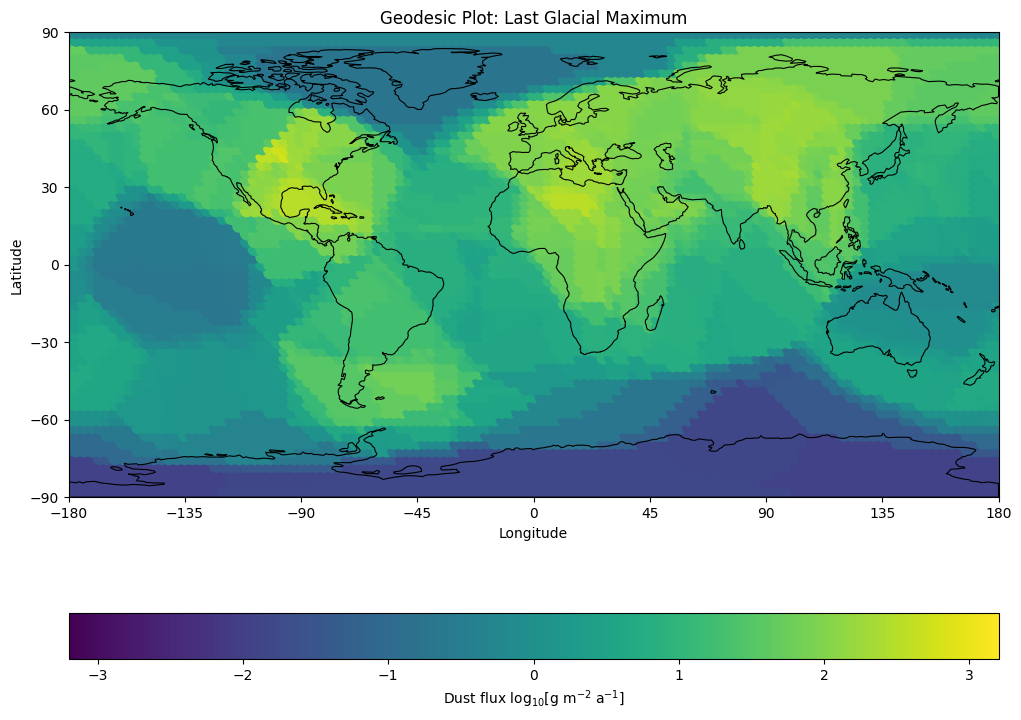

In [18]:
# Geodesic Plot
plot_dust_deposition_map(df=df_global_grid,
                         title='Geodesic Plot: Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Geodesic Plot: Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [19]:
estimations_holocene_euclidean = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_euclidean = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_euclidean[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm_euclidean[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene_euclidean
df_global_grid["est_lgm"] = estimations_lgm_euclidean

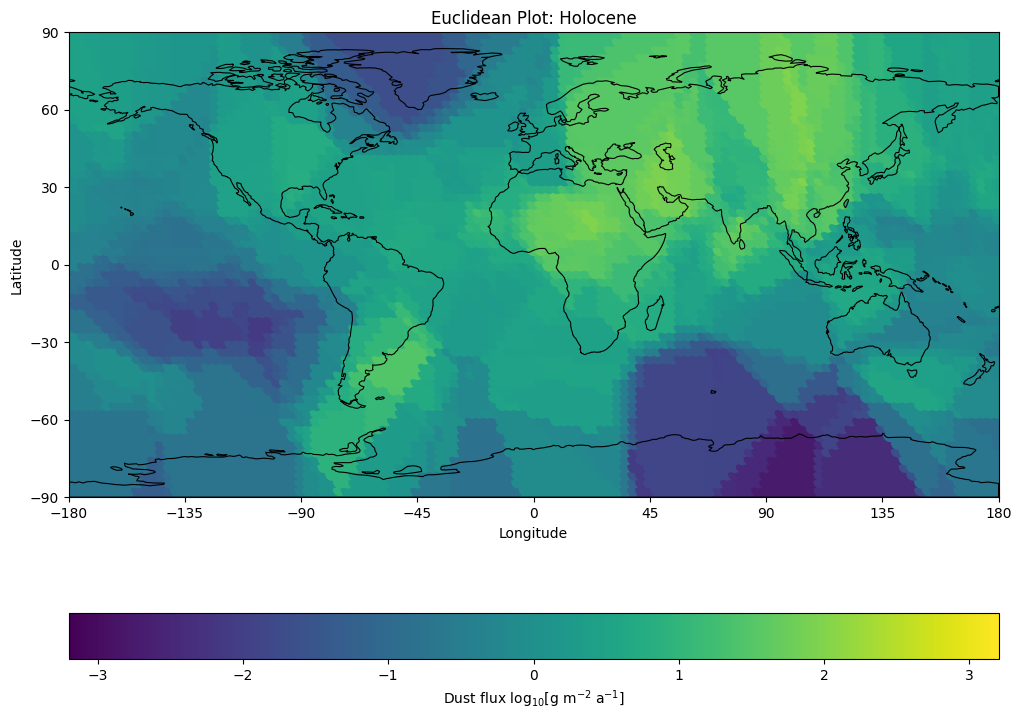

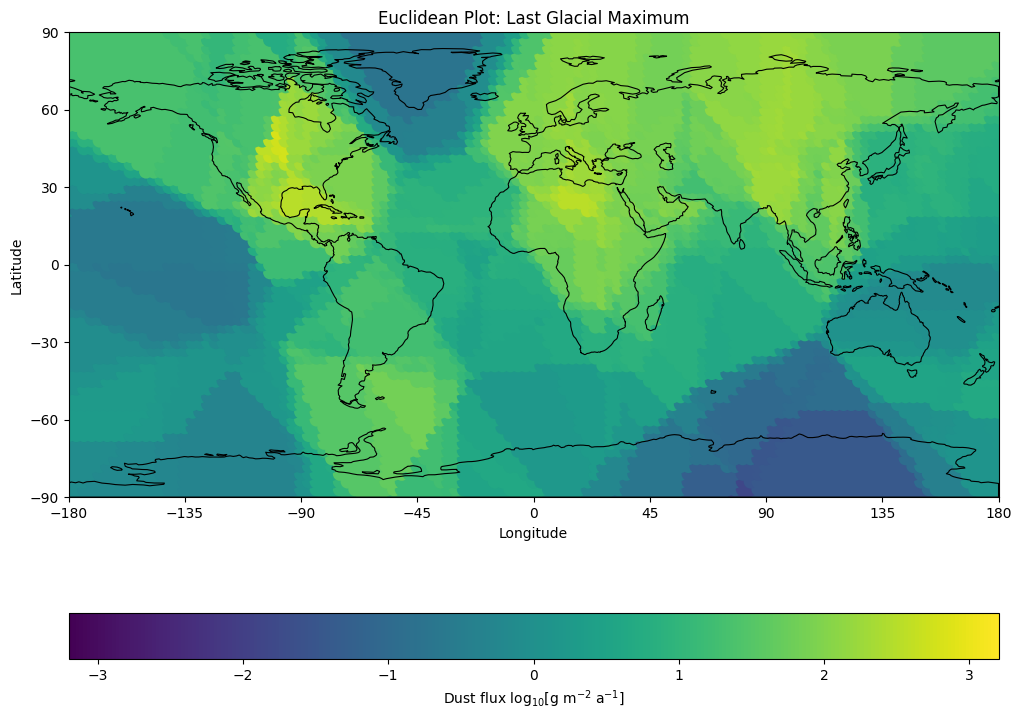

In [20]:
# Euclidean plot
plot_dust_deposition_map(df=df_global_grid,
                         title='Euclidean Plot: Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Euclidean Plot: Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

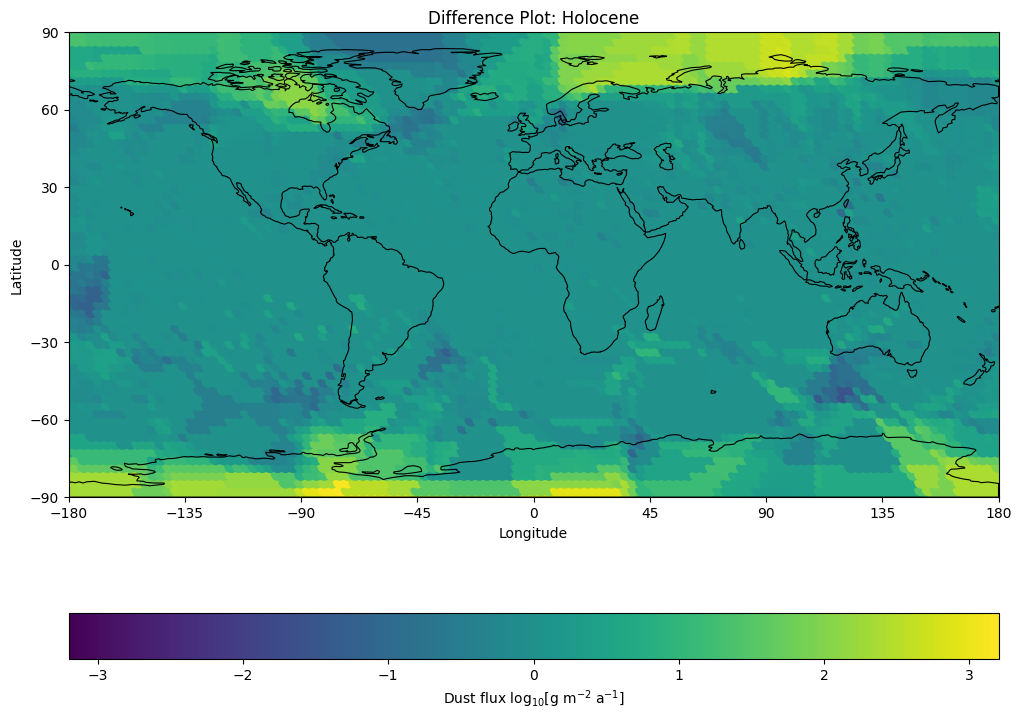

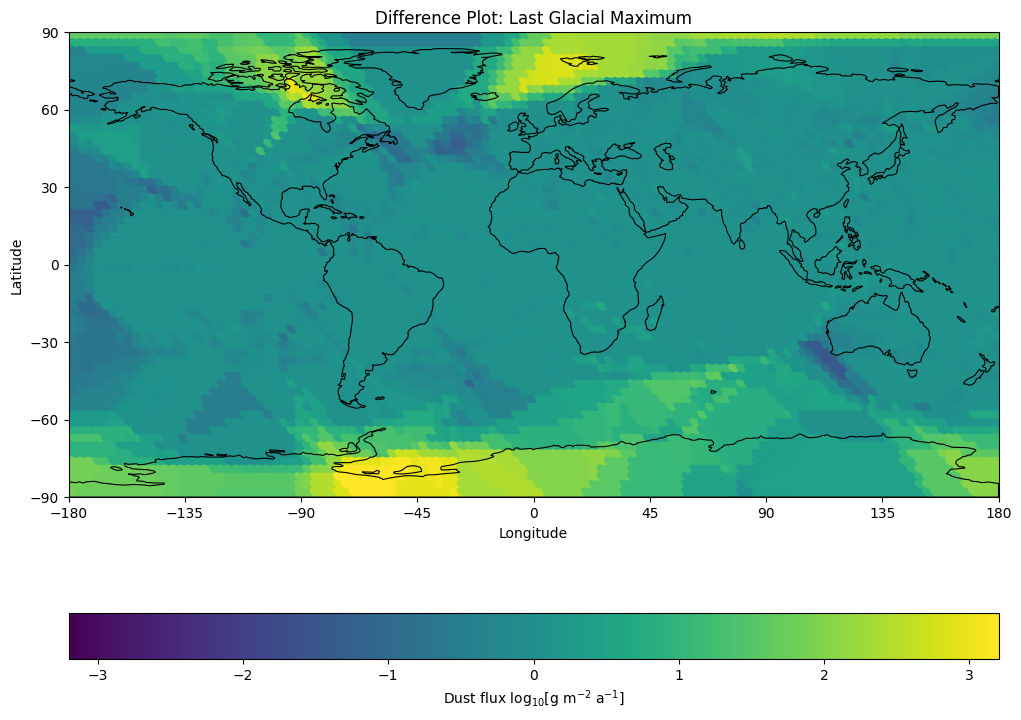

In [21]:
# Difference plot
df_global_grid["est_hol"] = estimations_holocene_euclidean - estimations_holocene_geodesic
df_global_grid["est_lgm"] = estimations_lgm_euclidean - estimations_lgm_geodesic

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference Plot: Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference Plot: Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

# Discusión
Tras haber investigado -a un gran nivel- la problemática que estamos analizando, a continuación se responden las preguntas planteadas:


* a) Por lo comprendido tras haber investigado más respecto a la problemática que estamos analizando, estas diferencias ocurren debido a la disposición de las corrientes de viento.

* b) El método más fidedigno en los polos sur y norte es el método geodesico, pues, a diferencia del método euclidanio, este sí considera la distorción generada por la curvatura de la tierra. Mientras que el método euclidiano, entre más nos alejemos del punto que queremos medir, más se distorsionará los valores.

* c) El método más fidedigno para la lognitud 180 grados es el método geodesico, ya que, tal como explicamos anteriormente, aunque el método geodesico y euclidanio poseen valores similares en cercanía a los puntos, a medida que nos alejamos este último distorsionará los valores.

* d) Las diferencias entre los resultados de ambos métodos se ve representada geográficamente en las zonas alejadas de puntos de medición; por ejemplo, el artico ruso o la peninsula antártica, lugares sin puntos de medición, poseen las diferencias de resultados más grandes.

* e) El número de vecinos cercanos se puede seleccionar de manera arbitraria dependiendo de cuántos puntos de medición queramos considerar en nuestra medición en cierto punto.




